In [1]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Dataset/E-Commerce Data.csv',encoding='iso-8859-1' )
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom



## Linear regression - For one particular stock/product predict next month sales

In [3]:
# Select instances of StockCode 85123A
df = data[data['StockCode'] == '85123A'].copy()

# Create a new column in Year
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')
df['Month'] = df['InvoiceDate'].dt.month

# Drop remaining columns
df = df.drop(columns=['InvoiceNo','InvoiceDate', 'Description','CustomerID','Country'])

df['Price'] = df['Quantity'] * df['UnitPrice']

df = df.groupby('Month').agg({
    'Quantity': 'sum',
    'Price': 'sum'
}).reset_index()

df.head()

,Month,Quantity,Price
0,1,5522,15191.96
1,2,1874,5132.06
2,3,1982,5550.95
3,4,1907,5078.59
4,5,3991,11172.17


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

X = df.Month
X = X.values.reshape(-1, 1)
y = df.Price
y = y.values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Mean Squared Error: 38488188.120565034
Prediction for next month:  10744.232804232804


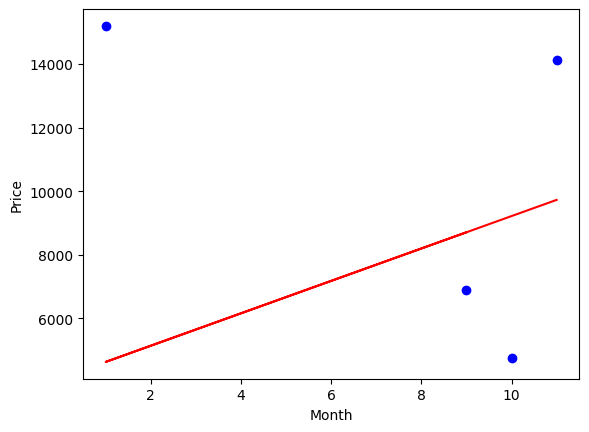

In [6]:
y_pred = model.predict(X_test)
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
prediction = model.predict([[13]])
print("Prediction for next month: ",prediction[0])
plt.scatter(X_test, y_test, color='blue')
plt.plot(X_test, y_pred, color='red')
plt.xlabel('Month')
plt.ylabel('Price')
plt.show()

## Logestic Regression - To Predict if a product (StockCode) will be purchased in a specific month

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Dataset/E-Commerce Data.csv',encoding='iso-8859-1' )


# Feature engineering
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Month'] = data['InvoiceDate'].dt.month
country_trends = data.groupby(['Country', 'Month']).agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'InvoiceNo': 'count'
}).reset_index()

# Create labels for classification
country_trends['Trend'] = pd.qcut(country_trends['InvoiceNo'], q=3, labels=['Low', 'Medium', 'High'])

# Prepare features and labels
X = country_trends[['Month', 'Quantity', 'UnitPrice']]
y = country_trends['Trend']

# Encode labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA for visualization purposes
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [13]:
# Tune the SVM model using GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}
svm_model = GridSearchCV(SVC(), param_grid, cv=5)
svm_model.fit(X_train_pca, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']})

Best Parameters: {'C': 100, 'kernel': 'linear'}
Accuracy: 0.5833333333333334
              precision    recall  f1-score   support

        High       0.86      0.60      0.71        20
         Low       0.52      0.70      0.60        20
      Medium       0.47      0.45      0.46        20

    accuracy                           0.58        60
   macro avg       0.62      0.58      0.59        60
weighted avg       0.62      0.58      0.59        60



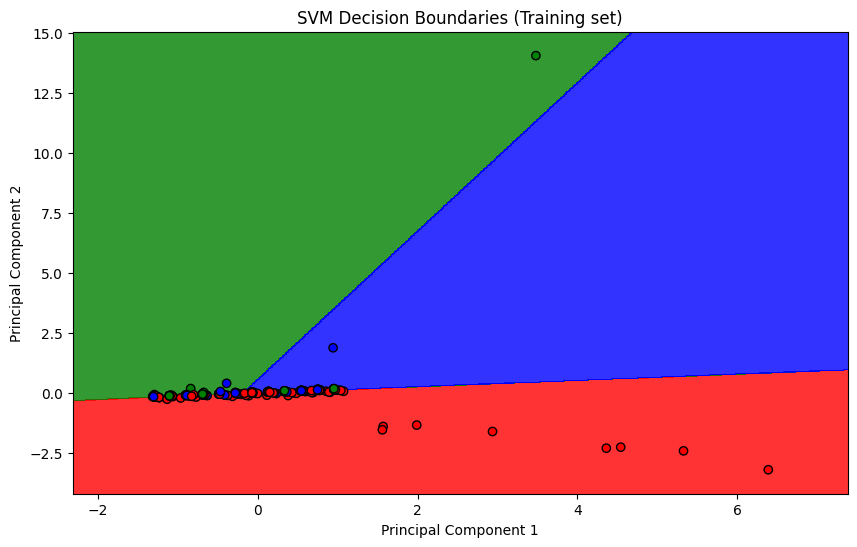

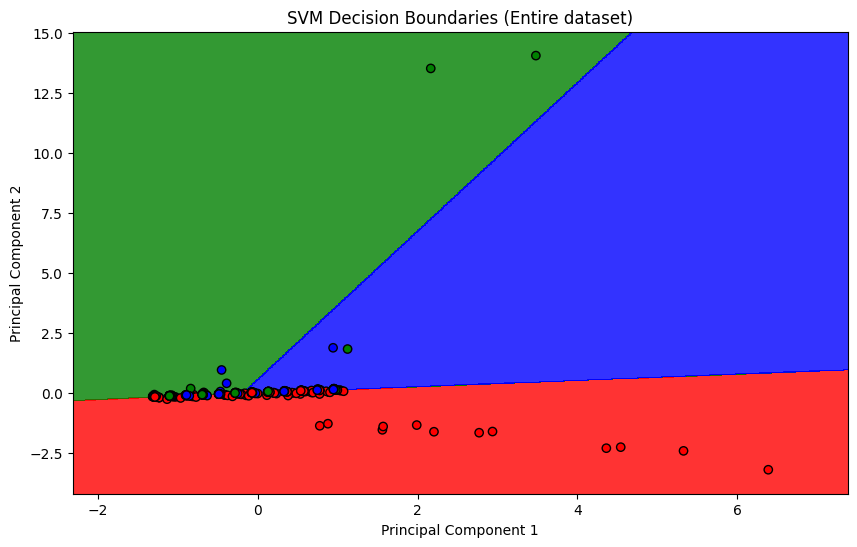

In [14]:
# Predict on the test data
y_pred = svm_model.predict(X_test_pca)

# Evaluate the model
print("Best Parameters:", svm_model.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Visualize the decision boundaries
def plot_decision_boundaries(X, y, model, title):
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(('red', 'green', 'blue')))
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=ListedColormap(('red', 'green', 'blue')))
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

plot_decision_boundaries(X_train_pca, y_train, svm_model, 'SVM Decision Boundaries (Training set)')

# Classify purchase trends on the entire dataset
country_trends_pca = pca.transform(scaler.transform(country_trends[['Month', 'Quantity', 'UnitPrice']]))
country_trends['Predicted_Trend'] = svm_model.predict(country_trends_pca)

plot_decision_boundaries(country_trends_pca, label_encoder.transform(country_trends['Trend']), svm_model, 'SVM Decision Boundaries (Entire dataset)')

 ## Decision Tree - To classify customers into different segments based on their purchasing behavior

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn import tree

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Dataset/E-Commerce Data.csv',encoding='iso-8859-1' )

# Feature engineering
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Month'] = data['InvoiceDate'].dt.month

# Aggregate data by CustomerID
customer_data = data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'Month': 'nunique',
    'Country': 'first'
}).reset_index()

# Create labels for classification
# Assume we categorize customers based on the quantity purchased into High-value, Frequent, and Occasional buyers
customer_data['TotalSpent'] = customer_data['Quantity'] * customer_data['UnitPrice']
customer_data['CustomerSegment'] = pd.qcut(customer_data['TotalSpent'], q=3, labels=['Occasional', 'Frequent', 'High-value'])

# Prepare features and labels
X = customer_data[['Quantity', 'UnitPrice', 'Month', 'Country']]
y = customer_data['CustomerSegment']

# Encode categorical variables
X = pd.get_dummies(X, columns=['Country'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
# Train the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Accuracy: 0.9794285714285714
              precision    recall  f1-score   support

    Frequent       0.99      0.96      0.97       292
  High-value       0.97      1.00      0.98       291
  Occasional       0.99      0.98      0.98       292

    accuracy                           0.98       875
   macro avg       0.98      0.98      0.98       875
weighted avg       0.98      0.98      0.98       875



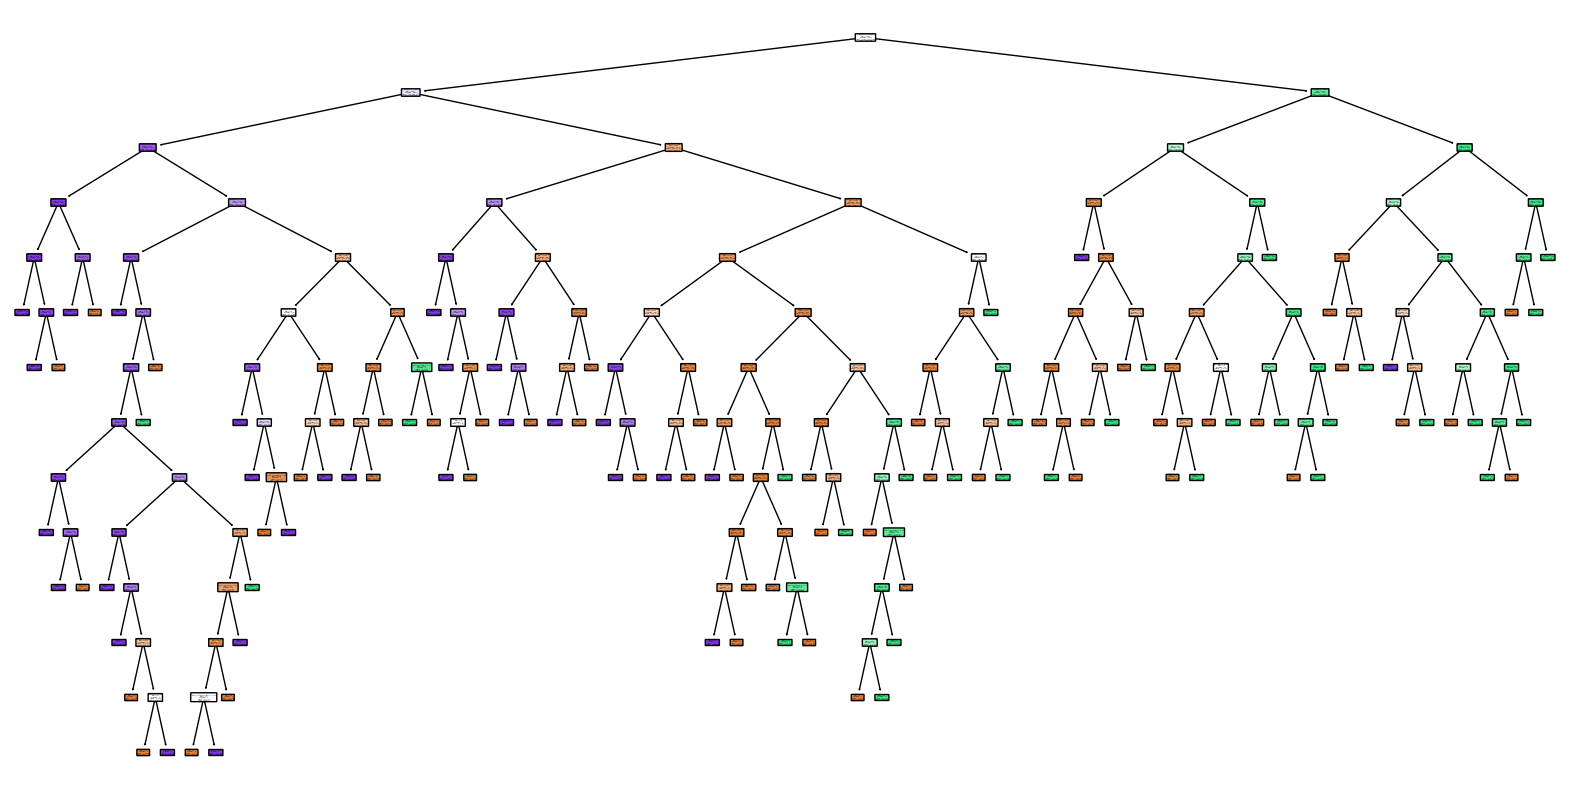

In [18]:
# Predict on the test data
y_pred = dt_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Visualize the Decision Tree
plt.figure(figsize=(20,10))
tree.plot_tree(dt_model, filled=True, feature_names=X.columns, class_names=dt_model.classes_, rounded=True)
plt.show()

## Random forest - Classify customers into different segments based on their purchasing behavior

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Dataset/E-Commerce Data.csv',encoding='iso-8859-1' )

# Feature engineering
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Month'] = data['InvoiceDate'].dt.month

# Aggregate data by CustomerID
customer_data = data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'Month': 'nunique',
    'Country': 'first'
}).reset_index()

# Create labels for classification
# Assume we categorize customers based on the quantity purchased into High-value, Frequent, and Occasional buyers
customer_data['TotalSpent'] = customer_data['Quantity'] * customer_data['UnitPrice']
customer_data['CustomerSegment'] = pd.qcut(customer_data['TotalSpent'], q=3, labels=['Occasional', 'Frequent', 'High-value'])

# Prepare features and labels
X = customer_data[['Quantity', 'UnitPrice', 'Month', 'Country']]
y = customer_data['CustomerSegment']

# Encode categorical variables
X = pd.get_dummies(X, columns=['Country'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Accuracy: 0.968
              precision    recall  f1-score   support

    Frequent       0.96      0.95      0.95       292
  High-value       0.97      0.98      0.98       291
  Occasional       0.98      0.97      0.97       292

    accuracy                           0.97       875
   macro avg       0.97      0.97      0.97       875
weighted avg       0.97      0.97      0.97       875



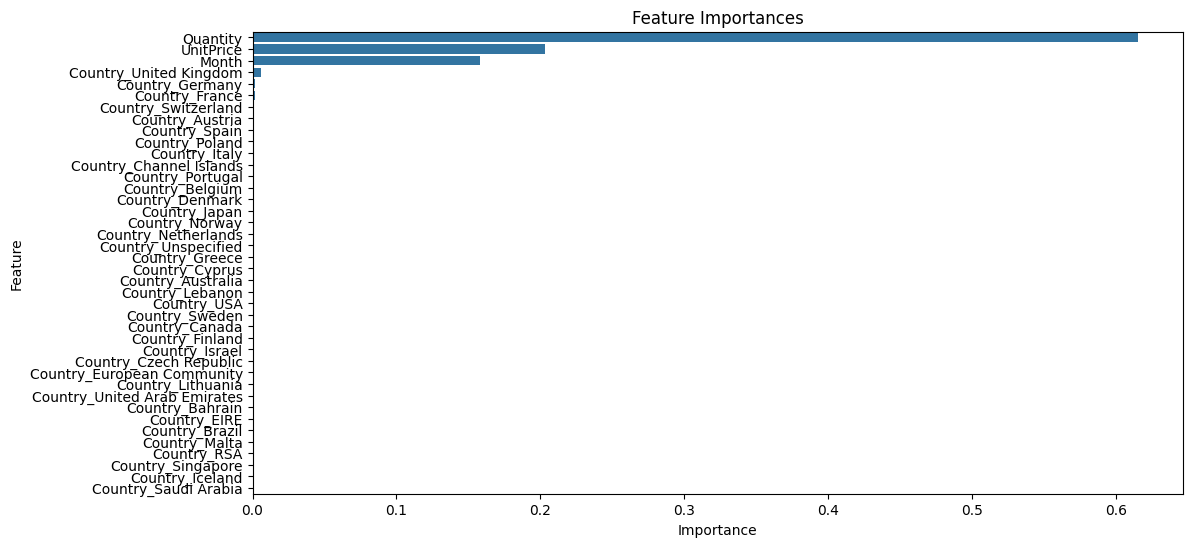

In [22]:
# Predict on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature Importance
feature_importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Dataset/E-Commerce Data.csv',encoding='iso-8859-1' )

# Feature engineering
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Month'] = data['InvoiceDate'].dt.month

# Aggregate data by CustomerID
customer_data = data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'Month': 'nunique',
    'Country': 'first'
}).reset_index()

# Create labels for classification
# Assume we categorize customers based on the quantity purchased into High-value, Frequent, and Occasional buyers
customer_data['TotalSpent'] = customer_data['Quantity'] * customer_data['UnitPrice']
customer_data['CustomerSegment'] = pd.qcut(customer_data['TotalSpent'], q=3, labels=['Occasional', 'Frequent', 'High-value'])

# Prepare features and labels
X = customer_data[['Quantity', 'UnitPrice', 'Month', 'Country']]
y = customer_data['CustomerSegment']

# Encode categorical variables
X = pd.get_dummies(X, columns=['Country'])

# Encode the target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
# Train the Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

Accuracy: 0.38742857142857146
              precision    recall  f1-score   support

    Frequent       0.18      0.01      0.01       292
  High-value       0.86      0.16      0.28       291
  Occasional       0.36      0.99      0.53       292

    accuracy                           0.39       875
   macro avg       0.47      0.39      0.27       875
weighted avg       0.47      0.39      0.27       875



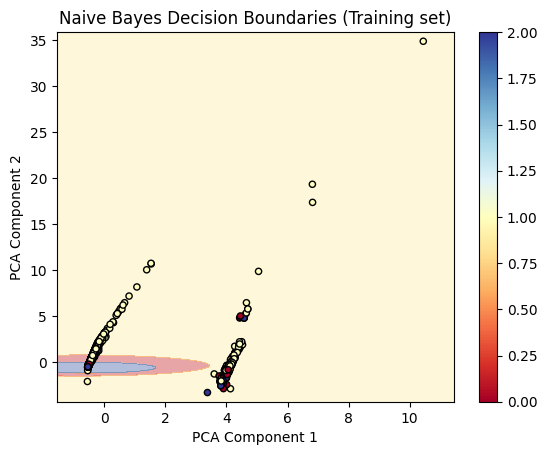

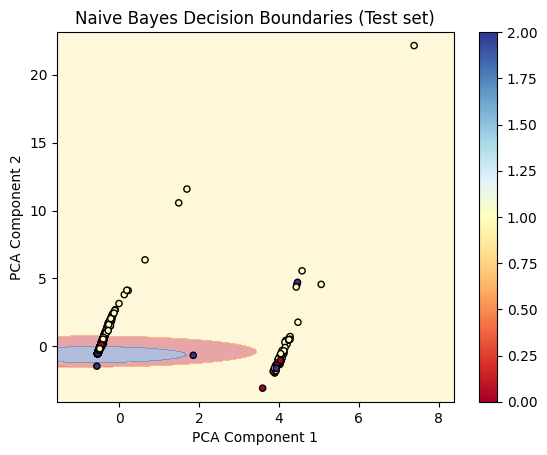

In [37]:
# Predict on the test data
y_pred = nb_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Re-train the model on PCA-transformed data
nb_model_pca = GaussianNB()
nb_model_pca.fit(X_train_pca, y_train)

# Plot decision boundaries
def plot_decision_boundaries(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.RdYlBu)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter)
    plt.show()

plot_decision_boundaries(X_train_pca, y_train, nb_model_pca, 'Naive Bayes Decision Boundaries (Training set)')
plot_decision_boundaries(X_test_pca, y_test, nb_model_pca, 'Naive Bayes Decision Boundaries (Test set)')

## K-Nearest Neighbors (KNN) - Customer Segmentation

Accuracy: 0.7851428571428571
              precision    recall  f1-score   support

    Frequent       0.69      0.68      0.69       292
  High-value       0.85      0.83      0.84       291
  Occasional       0.81      0.84      0.83       292

    accuracy                           0.79       875
   macro avg       0.79      0.79      0.79       875
weighted avg       0.79      0.79      0.79       875



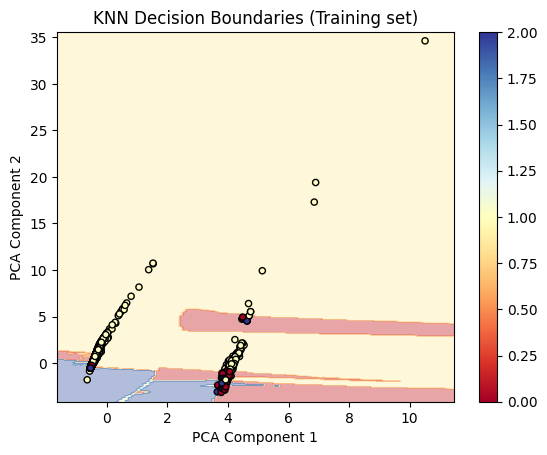

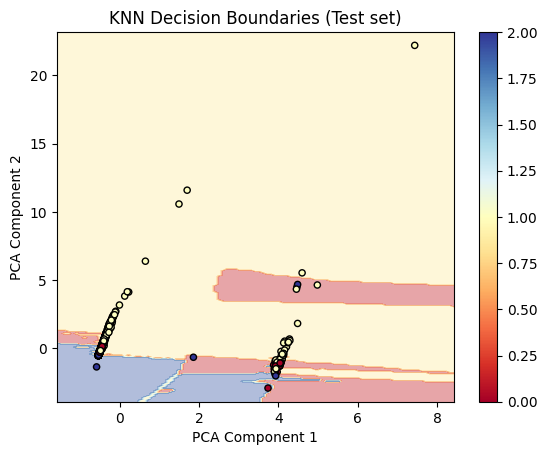

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Dataset/E-Commerce Data.csv',encoding='iso-8859-1' )

# Feature engineering
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Month'] = data['InvoiceDate'].dt.month

# Aggregate data by CustomerID
customer_data = data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'Month': 'nunique',
    'Country': 'first'
}).reset_index()

# Create labels for classification
# Assume we categorize customers based on the quantity purchased into High-value, Frequent, and Occasional buyers
customer_data['TotalSpent'] = customer_data['Quantity'] * customer_data['UnitPrice']
customer_data['CustomerSegment'] = pd.qcut(customer_data['TotalSpent'], q=3, labels=['Occasional', 'Frequent', 'High-value'])

# Prepare features and labels
X = customer_data[['Quantity', 'UnitPrice', 'Month', 'Country']]
y = customer_data['CustomerSegment']

# Encode categorical variables
X = pd.get_dummies(X, columns=['Country'])

# Encode the target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_pca, y_train)

# Predict on the test data
y_pred = knn_model.predict(X_test_pca)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot decision boundaries
def plot_decision_boundaries(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.RdYlBu)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter)
    plt.show()

plot_decision_boundaries(X_train_pca, y_train, knn_model, 'KNN Decision Boundaries (Training set)')
plot_decision_boundaries(X_test_pca, y_test, knn_model, 'KNN Decision Boundaries (Test set)')